# Finetuning SMILES-BERT

Now that we've performed some dimension reduction and unsupervised learning on the smiles strings, I thought that it would be interesting to attempt some supervised learning methods including zero-shot learning from the SMILES-BERT embeddings and finetuning the language model to perform better on the downstream tasks

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%env WANDB_PROJECT=smiles_bert_finetuning
%env WANDB_LOG_MODEL=all

env: WANDB_PROJECT=smiles_bert_finetuning
env: WANDB_LOG_MODEL=all


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import wandb
import datasets
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForMaskedLM
from optimum.bettertransformer import BetterTransformer

tqdm.pandas()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/stephenlu/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
wandb.login()

True

In [52]:
compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)

flavor_content = pd.read_csv('data/CompoundsFlavor.csv', header=0, index_col=0)
flavors = pd.read_csv('data/Flavor.csv', header=0, index_col=0)

ontology_content = pd.read_csv('data/CompoundOntologyTerm.csv', header=0, index_col=0)
ontology = pd.read_csv('data/OntologyTerm.csv', header=0, index_col=0)

health_content = pd.read_csv('data/CompoundsHealthEffect.csv', header=0, index_col=0)
health = pd.read_csv('data/HealthEffect.csv', header=0, index_col=0)

/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_42456/133091856.py:1: DtypeWarning: Columns (3,4,5,6,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  compounds = pd.read_csv('data/Compound.csv', header=0, index_col=0)


In [53]:
cur_content = flavor_content
cur_df = flavors
id_col = 'superklass'

In [54]:
smiles = compounds.merge(cur_content, left_index=True, right_on="compound_id")
smiles = smiles[smiles['compound_id'] != 29634]
len(smiles)

10239

In [55]:
smiles = smiles.dropna(subset=['cas_number', id_col])
top_terms = smiles.groupby([id_col])[id_col].count()
top_terms

superklass
Alkaloids and derivatives                    8
Benzenoids                                 678
Homogeneous non-metal compounds              5
Hydrocarbon derivatives                     19
Hydrocarbons                                15
Lipids and lipid-like molecules            884
Nucleosides, nucleotides, and analogues      3
Organic acids and derivatives              259
Organoheterocyclic compounds               448
Organonitrogen compounds                    21
Organooxygen compounds                     619
Organosulfur compounds                     156
Phenylpropanoids and polyketides           124
Name: superklass, dtype: int64

In [56]:
t = top_terms.to_frame()
final_df = t.merge(cur_df, left_index=True, right_index=True)
final_df.nlargest(10, id_col)

,superklass,name,flavor_group,category,created_at,updated_at,creator_id,updater_id


In [57]:
targets = top_terms.nlargest(7)
smiles = smiles[smiles[id_col].isin(targets.index)]

In [58]:
target_idx = list(targets.index)
df_final = smiles[['cas_number', id_col]]
df_final[id_col] = df_final[id_col].apply(lambda x: target_idx.index(x))
df_final.rename(columns={id_col: 'label', 'cas_number': 'sequence'}, inplace=True)
df_final.dropna(inplace=True)

/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_42456/4056994991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[id_col] = df_final[id_col].apply(lambda x: target_idx.index(x))
/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_42456/4056994991.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={id_col: 'label', 'cas_number': 'sequence'}, inplace=True)
/var/folders/ln/wx93hvrs02d003t516fpf0xc0000gn/T/ipykernel_42456/4056994991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

<Axes: >

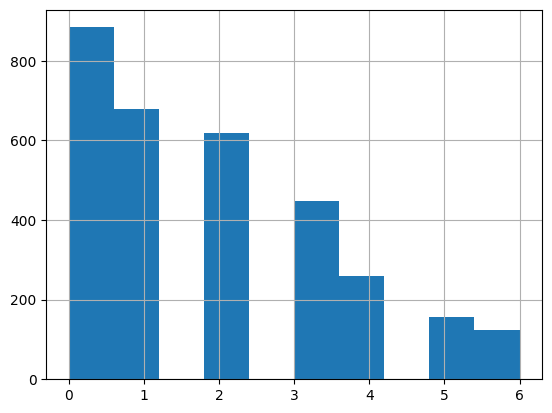

In [59]:
# Plot the class distribution
df_final['label'].hist()

## Create train, val, test split & Tokenize

In [60]:
dataset = datasets.Dataset.from_pandas(df_final)
dataset = dataset.train_test_split(test_size=0.2)
test_valid = dataset['test'].train_test_split(test_size=0.5)
dataset = datasets.DatasetDict({
    'train': dataset['train'],
    'valid': test_valid['train'],
    'test': test_valid['test']
})

In [61]:
dataset['train'][200]

{'sequence': 'CC(=O)OCCC1=CC=CC=C1', 'label': 1, 'id': 741}

In [62]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k", use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["sequence"], padding="max_length", truncation=True)

In [63]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|                                      | 0/2534 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████████████████████| 317/317 [00:00<00:00, 31296.36 examples/s]


In [64]:
tokenized_datasets['valid'].shape

(317, 5)

## Training the model

In [65]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate

In [66]:
model = AutoModelForSequenceClassification.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k", num_labels=len(targets))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [70]:
training_args = TrainingArguments(
    output_dir="results/finetuning/superklass",
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    logging_steps=100,
    report_to="wandb",
    run_name="superklass-classifier-top-7"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()

TypeError: Trainer.__init__() got an unexpected keyword argument 'test_dataset'

In [ ]:
trainer.evaluate(tokenized_datasets['test'])
wandb.finish()

## Re-Visualize with new embeddings

In [21]:
# Load the model from a checkpoint

model = AutoModelForSequenceClassification.from_pretrained("results/finetuning/superklass/checkpoint-636", num_labels=len(targets))
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [22]:
def get_embeddings(smiles_string: str):
    inputs = tokenizer(smiles_string, return_tensors="pt", padding="max_length", truncation=True).to('mps')    
    cls_token_id = tokenizer.cls_token_id
    hidden_st = model(**inputs, output_hidden_states=True).hidden_states  
    return hidden_st[-1][0, cls_token_id, :]

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [23]:
smiles_embeds = smiles['cas_number'].progress_apply(get_embeddings)

100%|███████████████████████████████████████| 3168/3168 [01:24<00:00, 37.69it/s]


In [25]:
from sklearn.decomposition import PCA

# smiles_embeds.dropna(inplace=True)
# X = [x.cpu().detach().numpy() for x in smiles_embeds]
y = np.array(smiles['superklass'].fillna('unknown'))

# These are the kingdom labels that we will use for clustering
target_names, y = np.unique(y, return_inverse=True)

# Run pca
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Get plot
values = list(range(len(target_names)))
cmap = plt.colormaps['tab10']
colors = cmap.colors[:len(target_names)]
lw = 1.2

# Plot details
plot_title = "PCA of superklass after finetuning (top7)"
plot_filename = "results/plots/pca_compound_superklass_finetuned_top7.png"

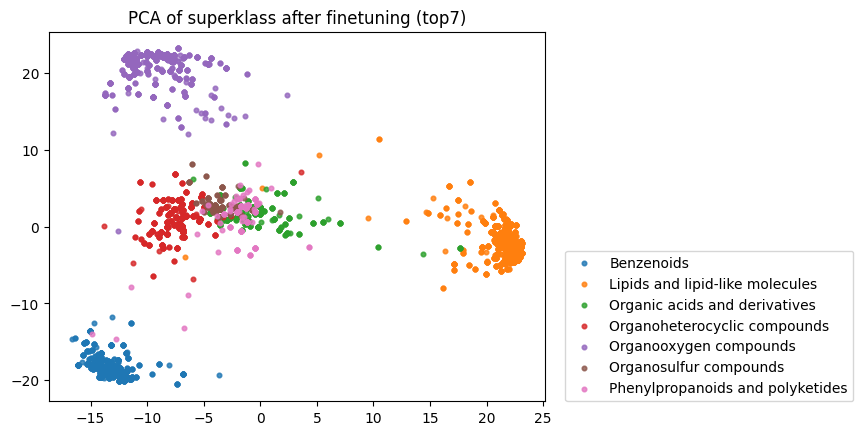

In [26]:
# Plot data
plt.figure()
for color, i, target_name in zip(colors, values, target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], s=10, color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc=(1.04, 0), shadow=False, scatterpoints=1)
plt.title(plot_title)
plt.savefig(plot_filename, bbox_inches='tight')

In [27]:
# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio (first two components): [0.27633407 0.22840783]
